# Isotherm modelling

In this notebook we'll attempt to model isotherms using the included models. First, make sure the data is imported by running the import notebook.

In [1]:
%run import.ipynb
import matplotlib.pyplot as plt

Selected 1 samples
Selected 23 adsorbates
Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric heat calculation


## Selecting models

Instead of using the raw creation method for models, we'll use the already available PointIsotherms, together with the `from_pointisotherm` class method. Let's select one of the isotherms and attempt to model it with the Double Site Langmuir model. It is worth noting that, if the branch is not selected, the model will automatically select the adsorption branch.

Attempting to model using DSLangmuir
Model DSLangmuir success, rmse is 0.33907724696364994


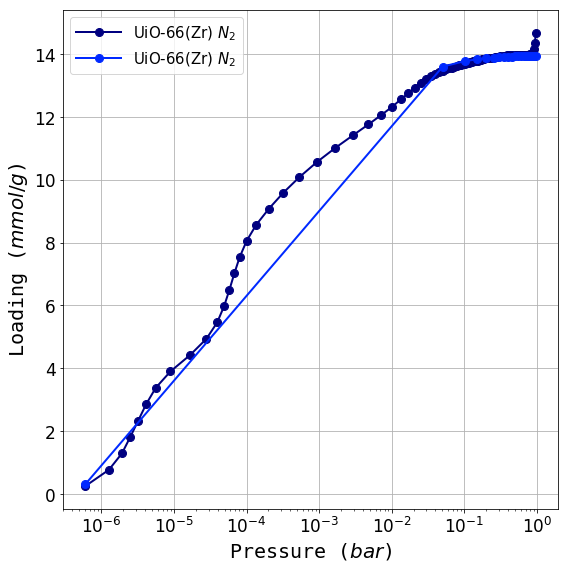

In [2]:
isotherm = next(i for i in isotherms_n2_77k if i.material_name=='UiO-66(Zr)')
model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                model='DSLangmuir', 
                                                verbose=True)

pygaps.plot_iso([isotherm, model], logx=True, branch='ads')
plt.show()

The fit seems good from the rms value, but the graph looks like it has a step at low pressure. This is just how the plotting method is designed. If we want to see the isotherm overlap at each point, we'll need to first create another PointIsotherm from the ModelIsotherm we have. In the class method we pass the original isotherm as a source for pressures where to calculate the loading.

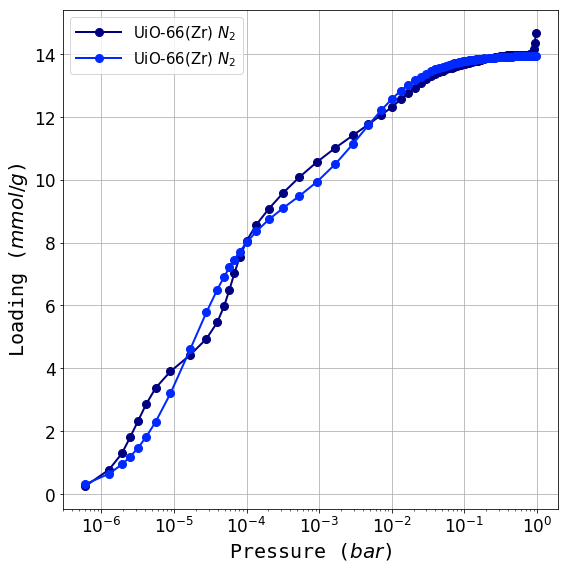

In [3]:
model_atpoints = pygaps.PointIsotherm.from_modelisotherm(model, 
                                                        pressure_points=isotherm)

pygaps.plot_iso([isotherm, model_atpoints], logx=True, branch='ads')
plt.show()

The original model is therefore reasonably good! It's important to note that the ModelIsotherm has almost all the methods that the PointIsotherm has. For example:

Material: UiO-66(Zr)
Batch: Test
Adsorbate used: N2
Isotherm temperature: 77.355K
Isotherm type: Isotherme
Machine: Triflex
User: PI
Activation temperature: 200.0°C
Source: MADIREL
Units: 
	Unit for loading: mmol/g
	Unit for pressure: bar
Other properties: 
	id: c08fcc234530bf2b52a58200cf13cda0
	branch: ads
	pressure_range: [6.04287137483e-07, 0.959627404777]
	loading_range: [0.257311, 14.6769]
	param_guess: {'M1': 8.072295, 'K1': 10549.891414235464, 'M2': 8.072295, 'K2': 15824.837121353195}
	rmse: 0.33907724696364994

DSLangmuir identified model parameters:
	M1 = 4.736528
	K1 = 243.331906
	M2 = 9.218244
	K2 = 59127.718378
RMSE =  0.33907724696364994


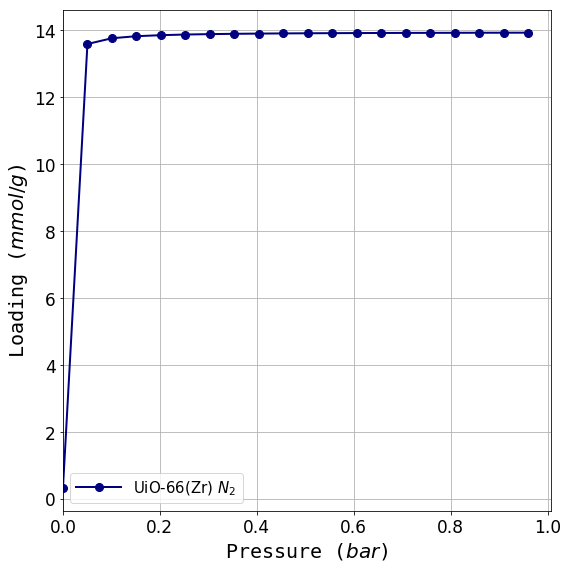

In [4]:
model.print_info(logx=False)

Let's now apply the same model to another isotherm.

In [5]:
isotherm = next(i for i in isotherms_n2_77k if i.material_name=='SiO2')
try:
    model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                model='DSLangmuir', 
                                                verbose=True)
except Exception as e:
    print(e)

Attempting to model using DSLangmuir

	Minimization of RSS for DSLangmuir isotherm fitting failed with error:
		Maximum number of function evaluations has been exceeded.
	Try a different starting point in the nonlinear optimization
	by passing a dictionary of parameter guesses, param_guess, to the
	constructor.
	Default starting guess for parameters:
	{'M1': 8.584125, 'K1': 18.22737529589921, 'M2': 8.584125, 'K2': 27.341062943848815}


Sometimes the model chosen will not fit the data, no matter how much we attempt to minimise the function.

## Guessing models

We also have the option of guessing a model instead. This option will calculate all available model fits and select the one with the smallest root mean square. Let's try this on the previous isotherm.

Attempting to model using Henry
Model Henry success, rmse is 1.5596143656313013
Attempting to model using Langmuir
Modelling using Langmuir failed
Attempting to model using DSLangmuir
Modelling using DSLangmuir failed
Attempting to model using TSLangmuir
Modelling using TSLangmuir failed
Attempting to model using Quadratic
Modelling using Quadratic failed
Attempting to model using BET
Model BET success, rmse is 0.47404896405717495
Attempting to model using TemkinApprox
Modelling using TemkinApprox failed
Attempting to model using Toth
Modelling using Toth failed
Attempting to model using Jensen-Seaton
Model Jensen-Seaton success, rmse is 1.559614365544207
Best model fit is BET


c:\users\paul\git\pygaps\src\pygaps\calculations\models_isotherm\jensenseaton.py:79: RuntimeWarning: invalid value encountered in power
  )**self.params['c'])**(- 1 / self.params['c'])


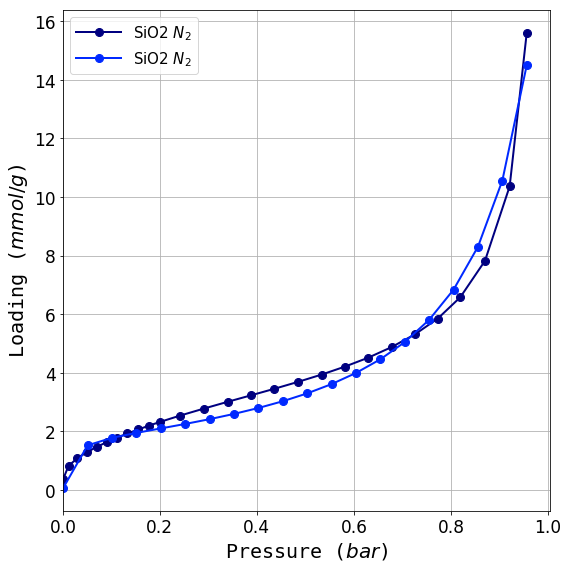

In [6]:
isotherm = next(i for i in isotherms_n2_77k if i.material_name=='SiO2')

model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                guess_model=True, 
                                                verbose=True)

pygaps.plot_iso([isotherm, model], branch='ads')
plt.show()

We can see that most models failed, but the BET model has been correctly identified as the best fitting one.

## Other options

We can also attempt to model the desorption branch of an isotherm.

c:\users\paul\git\pygaps\src\pygaps\calculations\models_isotherm\jensenseaton.py:79: RuntimeWarning: invalid value encountered in power
  )**self.params['c'])**(- 1 / self.params['c'])


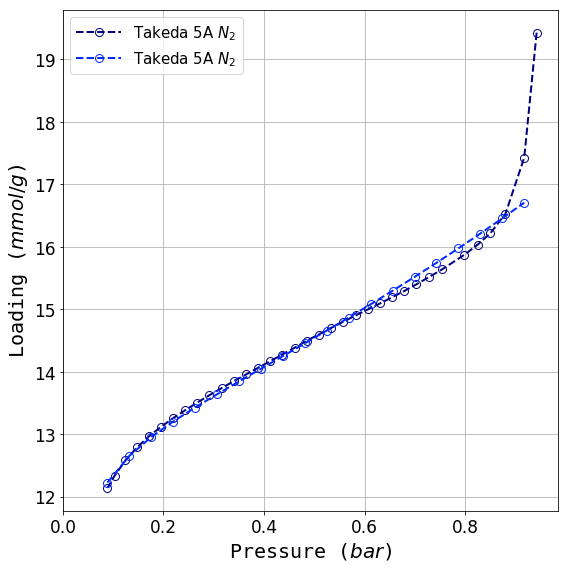

In [7]:
isotherm = next(i for i in isotherms_n2_77k if i.material_name=='Takeda 5A')

model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                guess_model=True,
                                                branch='des')

pygaps.plot_iso([isotherm, model], branch='des')
plt.show()

Just because a the minimisation has successfully produced a model that **does NOT mean** that the model is accurate. For example, trying to model the MCM-41 sample with a Langmuir model does not throw any errors but it is obvious that the model is not representative of the condensation in the pores.

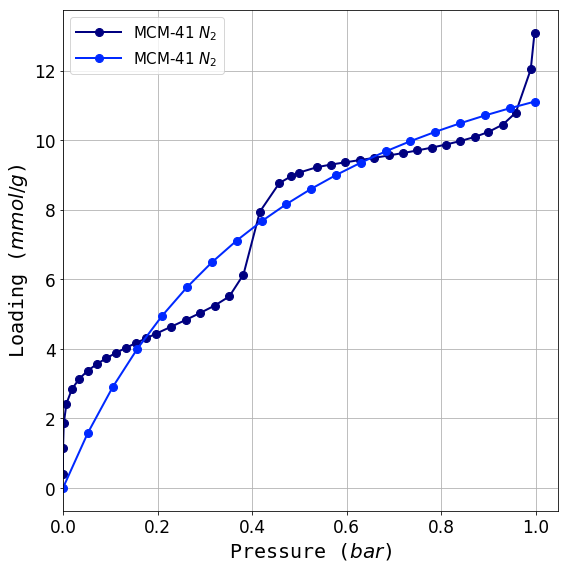

In [8]:
isotherm = next(i for i in isotherms_n2_77k if i.material_name=='MCM-41')

model = pygaps.ModelIsotherm.from_pointisotherm(isotherm, 
                                                model="DSLangmuir")

pygaps.plot_iso([isotherm, model], branch='ads')
plt.show()